<a href="https://colab.research.google.com/github/gilad-altshuler/Three_Body_RNN/blob/main/notebooks/4_MultiFate_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import sys, os
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Colab. Cloning repo...")
    !git clone https://github.com/gilad-altshuler/Beyond_Linear_Summation-Three_Body_RNNs.git
    %cd Beyond_Linear_Summation-Three_Body_RNNs
    ROOT = Path(".").resolve()

    # Load Arial font
    !wget -O Arial.ttf "https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf"

else:
    print("Not running in Colab.")
    ROOT = Path(__file__).resolve().parent.parent
    sys.path.append(str(ROOT))

In [ ]:
import torch
import random
from torch import nn
import numpy as np
import copy
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
%matplotlib inline
if IN_COLAB:
  fm.fontManager.addfont('Arial.ttf')
  arial_fp = fm.FontProperties(fname='Arial.ttf')
  plt.rcParams['font.family'] = arial_fp.get_name()
else:
  plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 10
import seaborn as sns


import utils
from tasks.MultiFate_task import generate_data
from Models import *

In [ ]:
DATA_DIR = ROOT / "data" / "multifate_inference"
FIG_DIR = ROOT / "notebooks" / "figures"

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
SEED = 3150
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Uncomment to generate new multifate data

In [ ]:
# N = 30 # n.o proteins
# T = 100
# data_size = 256
# params = (dt, Kd, n, alpha, beta, inducers) = (0.2,1,1.5,3.6,90.0,0)
# x_half, input = generate_data(data_size, T, N, *params)

TFs ON: 5, count: 2
TFs ON: 6, count: 18
TFs ON: 7, count: 19
TFs ON: 8, count: 52
TFs ON: 9, count: 78
TFs ON: 10, count: 471
TFs ON: 11, count: 197
TFs ON: 12, count: 695
TFs ON: 13, count: 363
TFs ON: 14, count: 501
TFs ON: 15, count: 1187
TFs ON: 16, count: 165
TFs ON: 17, count: 79
TFs ON: 18, count: 140
TFs ON: 19, count: 7
TFs ON: 20, count: 26


load preproccessed 15 high concentration at fixed point out of 30 TFs and zero input

In [ ]:
x_half = torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/MultiFate/x_15.pth",map_location=DEVICE)
input = torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/MultiFate/input.pth",map_location=DEVICE)

Dataset visualize and stats

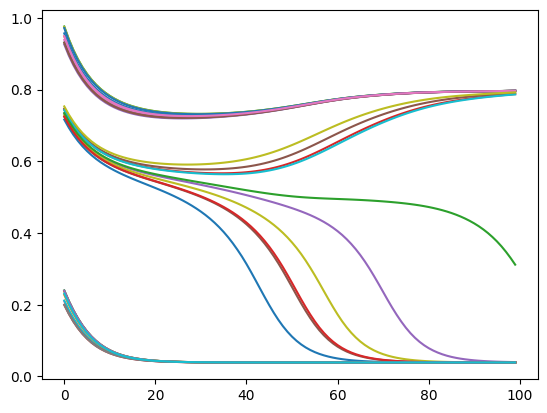

In [ ]:
_=plt.plot(x_half[-8].cpu().numpy())

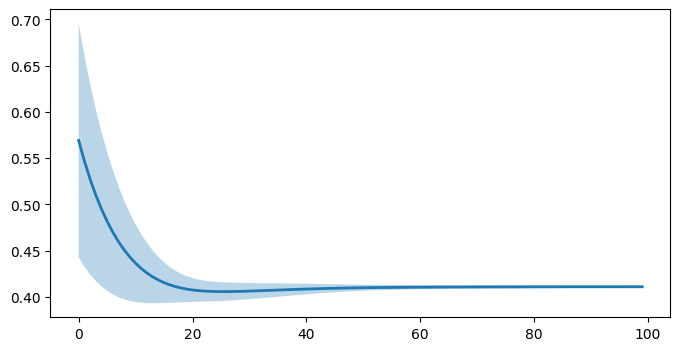

In [ ]:
plt.figure(figsize=(8, 4))
t= np.arange(T)
mean = x_half.mean(dim=-1).mean(dim=0).cpu().numpy()
std = x_half.mean(dim=-1).std(dim=0).cpu().numpy()
plt.plot(t,mean, label='Mean', linewidth=2)
plt.fill_between(t,mean - std, mean + std, alpha=0.3, label='±1 std')


Train RNN, TBRNN, HORNN to infer MultiFate 15 upregulated TFs

In [ ]:
from Models import *

input_size = output_size = hidden_dim = N
hidden = x_half[:,0,:]
w_out = torch.nn.Identity()

In [ ]:
# Uncomment to load pre-trained models
tbrnn_student = TBRNN(input_size, output_size, hidden_dim,
                      mode='cont', form='rate',nonlinearity=torch.tanh,output_nonlinearity=torch.sigmoid,task=None,noise_std=0.0,
                      tau=0.2, Win_bias=True,Wout_bias=True,w_out=w_out).to(DEVICE)
rnn_student = Full_Rank_RNN(input_size, output_size, hidden_dim,
                      mode='cont', form='rate',nonlinearity=torch.tanh,output_nonlinearity=torch.sigmoid,task=None,noise_std=0.0,
                      tau=0.2, Win_bias=True,Wout_bias=True,w_out=w_out).to(DEVICE)
hornn_student = HORNN(input_size, output_size, hidden_dim,
                      mode='cont', form='rate',nonlinearity=torch.tanh,output_nonlinearity=torch.sigmoid,task=None,noise_std=0.0,
                      tau=0.2, Win_bias=True,Wout_bias=True,w_out=w_out).to(DEVICE)

tbrnn_student.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/MultiFate/TBRNN.pth",map_location=DEVICE))
rnn_student.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/MultiFate/RNN.pth",map_location=DEVICE))
hornn_student.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/MultiFate/HORNN.pth",map_location=DEVICE))

<All keys matched successfully>

In [ ]:
from utils import cka

multifate = x_half[:,1:].reshape(-1,hidden_dim)

trajectory = rnn_student(input[:data_size,1:,:],x_half[:,0,:])[0].reshape(-1,hidden_dim).detach().clone()
rnn_cka_score = cka(multifate, trajectory)
torch.cuda.empty_cache()

trajectory = tbrnn_student(input[:data_size,1:,:],x_half[:,0,:])[0].reshape(-1,hidden_dim).detach().clone()
tbrnn_cka_score = cka(multifate, trajectory)
torch.cuda.empty_cache()

trajectory = hornn_student(input[:data_size,1:,:],x_half[:,0,:])[0].reshape(-1,hidden_dim).detach().clone()
hornn_cka_score = cka(multifate, trajectory)
torch.cuda.empty_cache()

print("RNN CKA similarity:", rnn_cka_score.item())
print("TBRNN CKA similarity:", tbrnn_cka_score.item())
print("HORNN CKA similarity:", hornn_cka_score.item())


RNN CKA similarity: 0.638539731502533
TBRNN CKA similarity: 0.9026860594749451
HORNN CKA similarity: 0.9306430816650391


visualize model - recurrent tensors

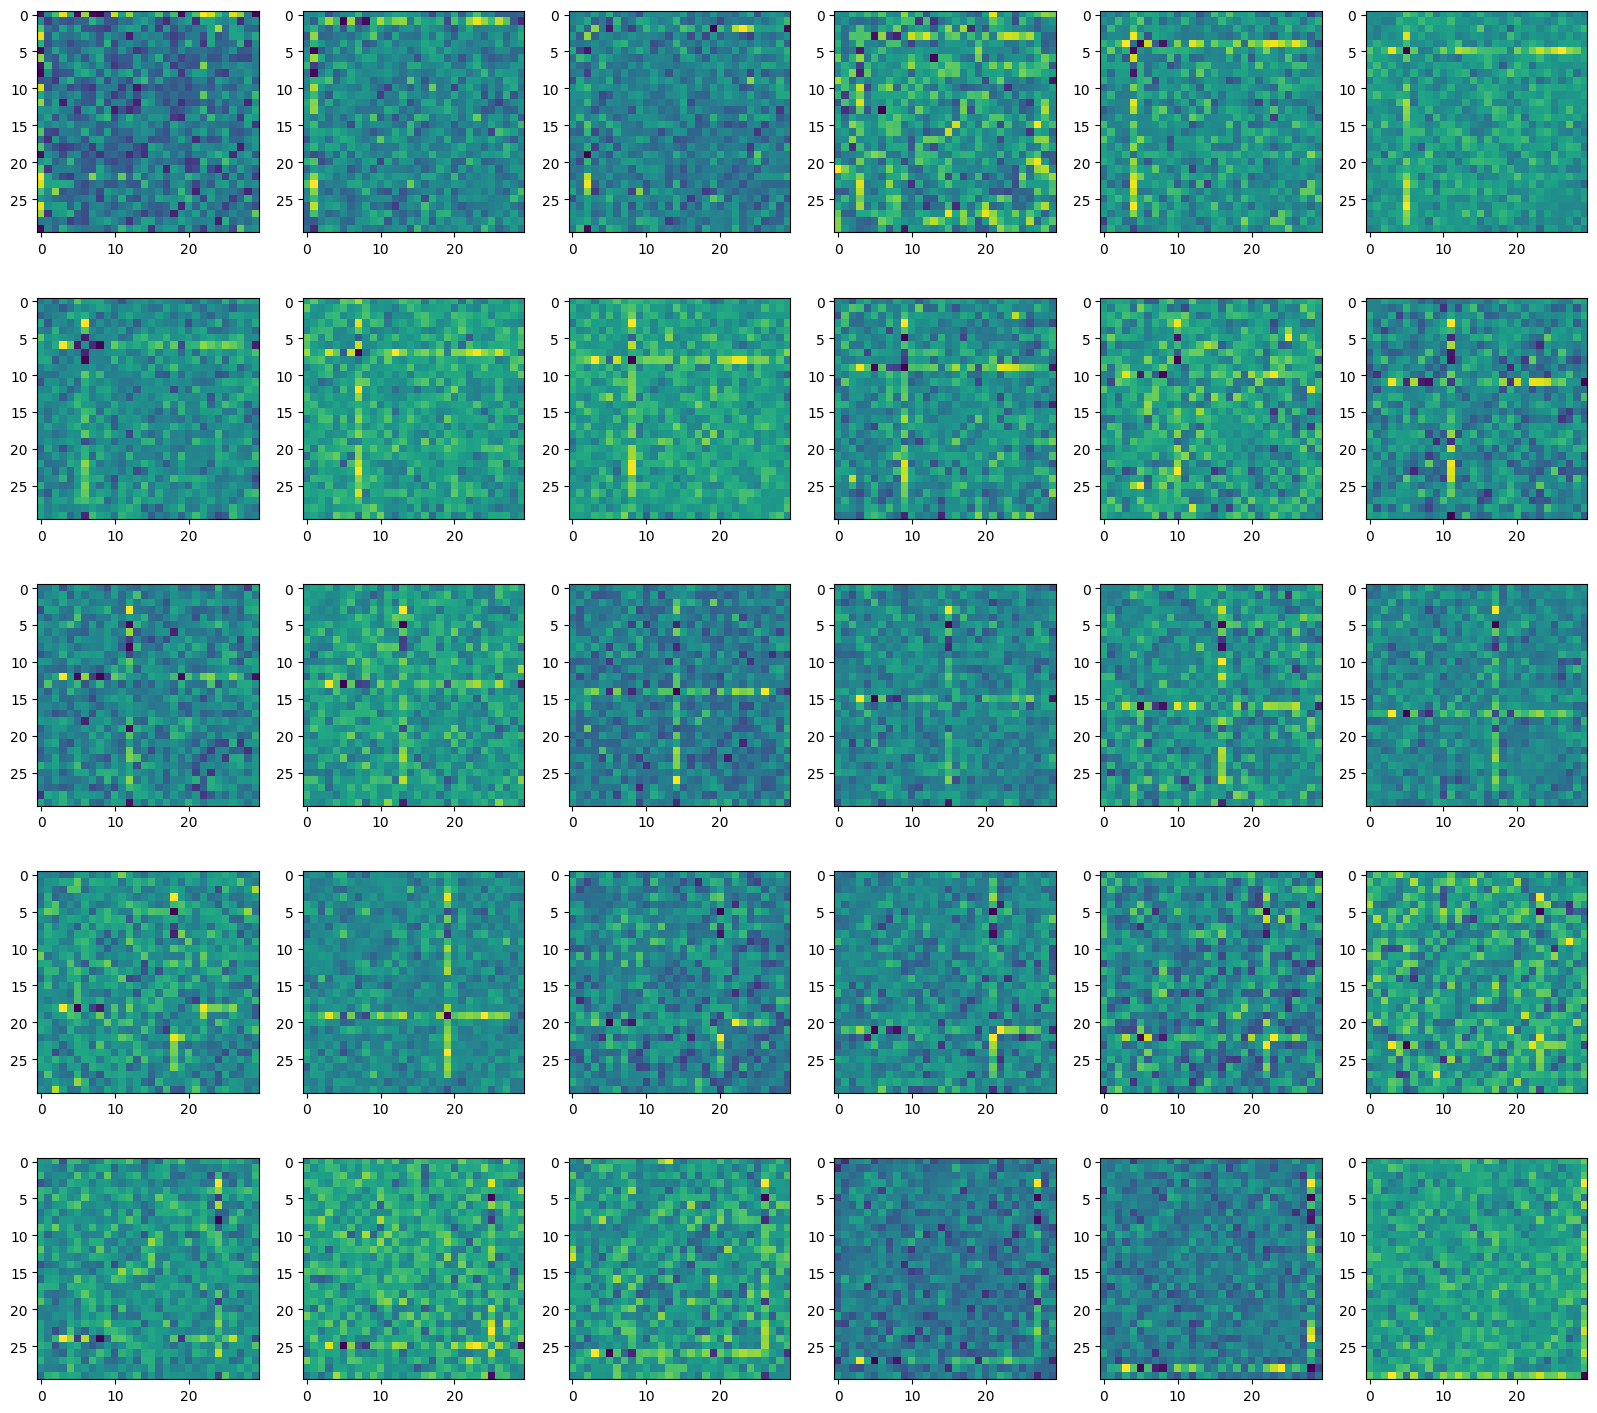

In [ ]:
W = hornn_student.w_hh_tbrnn
fig = plt.figure(figsize=(20, 18))
for i in range(hidden_dim):
    ax = fig.add_subplot(5, 6, i + 1)
    ax.imshow(W[i].cpu().detach().numpy(), aspect=1)

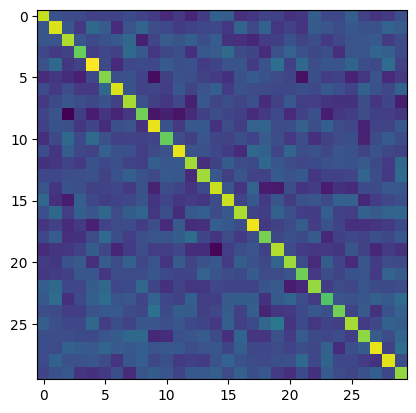

In [ ]:
W = hornn_student.w_hh_rnn
plt.imshow(W.cpu().detach().numpy())

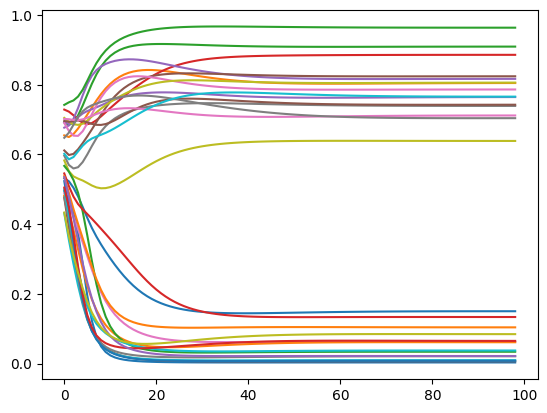

In [ ]:
_=plt.plot(hornn_student(input[:,1:,:],hidden)[0][2].cpu().detach().clone().numpy())

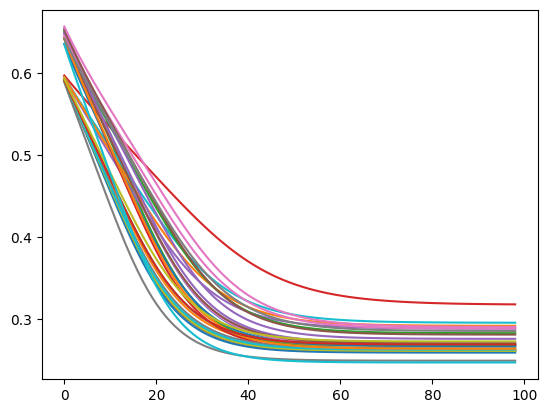

In [ ]:
_=plt.plot(rnn_student(input[:,1:,:],hidden)[0][0].cpu().detach().clone().numpy())

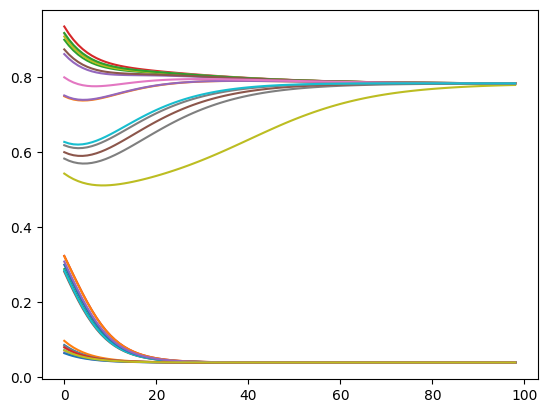

In [ ]:
_=plt.plot(x_half[2,1:].cpu().numpy())